# **Summary - Milestone 4**:

- Build a **Feature Importance** notebook (or notebooks):
  - Discuss feature importance
  - Conclusions

<br>

**Team Contributions**

The work of this notebook was distributed as follows:

| Name              | Contribution | Details                    |
|-------------------|--------------|----------------------------|
| Shashank Kushwaha |    25%       | Coordinate the group, started draft  notebooks, drafted initial code   |
| Johann J Cardenas |    25%       | Testing various feature importance implementation  |
| Manoj Lakshmi     |    25%       | Testing various feature importance implementation   |
| Nghia Dai Nguyen  |    25%       | Testing various feature importance implementation |

This distribution of effort was approved by

- Shashank Kushwaha (sk89@illinois.edu )
- Johann Cardenas Huaman (johannc2@illinois.edu)
- Manoj Lakshmi (lmanoj2@illinois.edu)
- Nghia Dai Nguyen (nghiadn2@illinois.edu)

# **Model Initialization**

In [1]:
import tensorflow as tf
from tensorflow import keras as tf_keras

In [2]:
import os
import pickle
import time

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import einops as ei

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.cm as cm

os.makedirs('results', exist_ok=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Initializing directory names
base_dir = 'drive/MyDrive/Deep_Dive_Project_Group_12'  # root directory
data_dir = os.path.join(base_dir, 'data_new')          # data directory

# **Step 1: Data Preprocessing**

In [5]:
df_full = pd.read_pickle(os.path.join(data_dir, 'all.pkl'))
df_full

,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1,99,U.S.,000000,Cross-industry,11-0000,Management Occupations,10495770.0,NaN,2023,66.23,137750.0,2.167487e+06,54.37,29.54
2,99,U.S.,000000,Cross-industry,11-1000,Top Executives,3751510.0,NaN,2023,65.43,136100.0,2.167487e+06,54.37,29.54
3,99,U.S.,000000,Cross-industry,11-1010,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
4,99,U.S.,000000,Cross-industry,11-1011,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633147,56,Wyoming,000000,Cross-industry,53-7071,Gas Compressor and Gas Pumping Station Operators,180.0,NaN,2011,27.08,56330.0,8.054832e+02,41.10,18.55
2633148,56,Wyoming,000000,Cross-industry,53-7073,Wellhead Pumpers,480.0,NaN,2011,20.64,42920.0,8.054832e+02,41.10,18.55
2633149,56,Wyoming,000000,Cross-industry,53-7081,Refuse and Recyclable Material Collectors,280.0,NaN,2011,14.82,30830.0,8.054832e+02,41.10,18.55
2633150,56,Wyoming,000000,Cross-industry,53-7111,Mine Shuttle Car Operators,80.0,NaN,2011,28.59,59460.0,8.054832e+02,41.10,18.55


We can see that the full dataset has lots of missing values. It is not a good idea to simply just drop all NaN the feature values.

In [6]:
df_full.isna().sum(axis=0)

,0
feature.area_code,0
feature.area_title,0
feature.naics_code,0
feature.naics_title,0
feature.occupation_code,0
feature.occupation_title,0
feature.total_employees,132851
feature.percentage_total,650720
feature.year,0
label.mean_hourly_wage,103300


Suppose we drop all these data, then the remaining dataframe only contains the data for the whole US, but does not contains any data that is state-specific. So we cannot drop the missing values but instead have to impute them. A simple strategy is to use the population average for each year.

In [7]:
df_full.dropna(
    subset=['feature.total_employees', 'feature.percentage_total', 'feature.new_college_degree']
)['feature.area_code'].value_counts()

,count
feature.area_code,
99,1976418


This cell will define if we will be running the whole dataset or just a subset of data. We will take the subset by occupation code.

In [8]:
occupation_code_df = df_full['feature.occupation_code'].value_counts()
display(occupation_code_df)

# Uncomment this for the whole dataset
# selected_occupation_code_df = occupation_code_df

# We sample across frequency of occupation counts to ensure
# the subset has similar properties to the full dataset
# Uncomment this for just a subset of the dataset
selected_occupation_code_df = occupation_code_df[::25]

,count
feature.occupation_code,
00-0000,6722
11-0000,6720
43-0000,6718
11-1021,6709
13-0000,6707
...,...
29-1243,47
11-9060,35
51-2060,34


We will see how many rows are there

In [9]:
occupation_code = selected_occupation_code_df.index.tolist()
print('Num samples in the selected set', selected_occupation_code_df.sum())
print('Percentage of the full dataset', selected_occupation_code_df.sum() / len(df_full) * 100, '%')

Num samples in the selected set 108540
Percentage of the full dataset 4.122055999805556 %


In [10]:
# the columns is just duplicated between title or code
# so we can simply select either of them
categorical_columns = [
    'feature.area_code',
    # 'feature.area_title',
    'feature.naics_code',
    # 'feature.naics_title',
    'feature.occupation_code',
    # 'feature.occupation_title'
]
# we don't need to do anything for numerical columns
numerical_columns = [
    'feature.total_employees',
    'feature.percentage_total',
    'feature.new_college_degree',
    'feature.avg_temperature',
    'feature.precipitation'
]

feature_columns = categorical_columns + numerical_columns
label_columns = [
    'label.mean_hourly_wage',
    'label.mean_annual_wage'
]

df_small = df_full[df_full['feature.occupation_code'].isin(occupation_code)].reset_index()
df_small

,index,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1,4,99,U.S.,000000,Cross-industry,11-1011,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
2,7,99,U.S.,000000,Cross-industry,11-1030,Legislators,32460.0,NaN,2023,NaN,68140.0,2.167487e+06,54.37,29.54
3,16,99,U.S.,000000,Cross-industry,11-2032,Public Relations Managers,72760.0,NaN,2023,76.65,159420.0,2.167487e+06,54.37,29.54
4,21,99,U.S.,000000,Cross-industry,11-3013,Facilities Managers,131400.0,NaN,2023,53.42,111110.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108535,2633009,56,Wyoming,000000,Cross-industry,47-2111,Electricians,2730.0,NaN,2011,25.14,52290.0,1.849693e+03,41.10,18.55
108536,2633072,56,Wyoming,000000,Cross-industry,49-9062,Medical Equipment Repairers,NaN,NaN,2011,18.73,38960.0,2.377415e+03,41.10,18.55
108537,2633085,56,Wyoming,000000,Cross-industry,51-3011,Bakers,290.0,NaN,2011,11.56,24050.0,3.330922e+03,41.10,18.55
108538,2633111,56,Wyoming,000000,Cross-industry,51-9011,Chemical Equipment Operators and Tenders,80.0,NaN,2011,31.61,65750.0,3.330922e+03,41.10,18.55


In [11]:
# we should not encode as one hot for the categorical values
# since we have lots of categories, the dataset would be too sparse
def transform_categorical_ordinal(categorical_df):
    encoder = OrdinalEncoder()
    encoded_categorical = encoder.fit_transform(categorical_df)
    new_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_df.columns))
    return encoder, new_categorical_df

def process_df(df):
    df = df.reset_index(drop=True)
    categorical_encoder, categorical_df = transform_categorical_ordinal(df[categorical_columns])
    return categorical_encoder, pd.concat(
        [
            categorical_df,
            df[numerical_columns],
            df[label_columns],
            df[['feature.year']]
        ],
        axis=1
    )

categorical_encoder, processed_df = process_df(df_small)

def scale_df(df):
    scaler = MinMaxScaler()
    use_df = df.drop('feature.year', axis=1)
    scaled_data = scaler.fit_transform(use_df)
    scaled_df = pd.DataFrame(scaled_data, columns=use_df.columns)
    return scaler, pd.concat([scaled_df, df[['feature.year']]], axis=1)

# it is better to scale the whole df
scaler, processed_df = scale_df(processed_df)
processed_df

,feature.area_code,feature.naics_code,feature.occupation_code,feature.total_employees,feature.percentage_total,feature.new_college_degree,feature.avg_temperature,feature.precipitation,label.mean_hourly_wage,label.mean_annual_wage,feature.year
0,1.000000,0.0,0.000000,1.000000e+00,NaN,NaN,0.462429,0.375992,0.068091,0.068076,2023
1,1.000000,0.0,0.016129,1.390811e-03,NaN,0.750455,0.462429,0.375992,0.337300,0.337305,2023
2,1.000000,0.0,0.032258,2.135606e-04,NaN,0.750455,0.462429,0.375992,NaN,0.071792,2023
3,1.000000,0.0,0.048387,4.789474e-04,NaN,0.750455,0.462429,0.375992,0.198859,0.198842,2023
4,1.000000,0.0,0.064516,8.651082e-04,NaN,0.750455,0.462429,0.375992,0.131608,0.131601,2023
...,...,...,...,...,...,...,...,...,...,...,...
108535,0.916667,0.0,0.822581,1.778026e-05,NaN,0.000617,0.087571,0.201493,0.049737,0.049731,2011
108536,0.916667,0.0,0.887097,NaN,NaN,0.000800,0.087571,0.201493,0.031179,0.031178,2011
108537,0.916667,0.0,0.903226,1.712173e-06,NaN,0.001130,0.087571,0.201493,0.010422,0.010425,2011
108538,0.916667,0.0,0.935484,3.292640e-07,NaN,0.001130,0.087571,0.201493,0.068467,0.068466,2011


In [12]:
def generate_data(df):
    X_data, Y_data = [], []
    drop_count = 0

    for _, group_df in tqdm(processed_df.groupby(categorical_columns)):
        num_features = len(feature_columns)
        num_years = 2023 - 2011 + 1
        x_data = np.full((num_years, num_features), fill_value=np.nan)
        y_data = np.full((num_years, len(label_columns)), fill_value=np.nan)

        # drop if have too few years
        if len(group_df) <= 6:
            drop_count += 1
            continue

        # assign features/labels to the correct year
        years = (group_df['feature.year'] - 2011).to_numpy().astype(int)
        x_data[years] = group_df[categorical_columns + numerical_columns].to_numpy()
        y_data[years] = group_df[label_columns].to_numpy()

        X_data.append(x_data)
        Y_data.append(y_data)

    X_data = np.array(X_data)
    Y_data = np.array(Y_data)

    # replace missing values with year-feature/label mean
    for year in range(2011, 2023 + 1):
        idx = year - 2021
        year_X_data = X_data[:, idx, :]
        year_Y_data = Y_data[:, idx, :]
        year_X_mean = np.nanmean(year_X_data, axis=0)
        year_Y_mean = np.nanmean(year_Y_data, axis=0)

        X_data[:, idx, :] = np.where(np.isnan(X_data[:, idx, :]), year_X_mean, X_data[:, idx, :])
        Y_data[:, idx, :] = np.where(np.isnan(Y_data[:, idx, :]), year_Y_mean, Y_data[:, idx, :])



    return X_data, Y_data, drop_count

X_data, Y_data, drop_count = generate_data(processed_df)
X_data.shape, Y_data.shape, drop_count

  0%|          | 0/12282 [00:00<?, ?it/s]

((7583, 13, 8), (7583, 13, 2), 4699)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6066, 13, 8), (1517, 13, 8), (6066, 13, 2), (1517, 13, 2))

# **Step 2: Model Architecture**

**Following cell uses custom definition of Integrated gradients. Works with tensorflow. Explanation for individual datapoints over timesteps**

In [14]:
# !pip install tf-explain

In [17]:
# Input and Output Shapes
timesteps = 13
features = 8
output_labels = 2

# Default training parameters
DEFAULT_BATCH_SIZE = 512
DEFAULT_NUM_EPOCHS = 50
DEFAULT_VALIDATION_SPLIT = 0.2

# Build Model
def create_model(input_shape, output_shape):
    input_layer = tf_keras.layers.Input(shape=input_shape)
    x = tf_keras.layers.LSTM(512, return_sequences=True, activation='relu', dropout=0.05, recurrent_dropout=0.05)(input_layer)
    x = tf_keras.layers.LSTM(512, return_sequences=True, activation='relu', dropout=0.05, recurrent_dropout=0.05)(x)
    x = tf_keras.layers.LSTM(512, return_sequences=True, activation='relu', dropout=0.05, recurrent_dropout=0.05)(x)
    output_layer = tf_keras.layers.TimeDistributed(tf_keras.layers.Dense(output_shape))(x)

    model = tf_keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=tf_keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf_keras.losses.MeanAbsoluteError(),
        metrics=[tf_keras.metrics.MeanSquaredError()]
    )
    return model

# Train the model
def train_model(
    model,
    X_train,
    y_train,
    batch_size=DEFAULT_BATCH_SIZE,
    num_epochs=DEFAULT_NUM_EPOCHS,
    validation_split=DEFAULT_VALIDATION_SPLIT
):
    early_stopping = tf_keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping],
        verbose=1
    )

    train_duration = time.time() - start_time
    return history, train_duration

# Train and evaluate the model
input_shape = (timesteps, features)
output_shape = output_labels

model = create_model(input_shape, output_shape)
history, train_duration = train_model(model, X_train, y_train)
print(f"Training completed in {train_duration:.2f} seconds.")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0506 - mean_squared_error: 0.0054 - val_loss: 0.0380 - val_mean_squared_error: 0.0035
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0355 - mean_squared_error: 0.0031 - val_loss: 0.0370 - val_mean_squared_error: 0.0036
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0341 - mean_squared_error: 0.0029 - val_loss: 0.0337 - val_mean_squared_error: 0.0029
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0334 - mean_squared_error: 0.0027 - val_loss: 0.0331 - val_mean_squared_error: 0.0028
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0320 - mean_squared_error: 0.0024 - val_loss: 0.0298 - val_mean_squared_error: 0.0020
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0303 - mean_squared_error: 0.0021 - val_loss: 0.0320 - val_mean_squared_error: 0.0028
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0294 - mean_squared_error: 0.0021 - val_loss: 0.0313 - val

In [ ]:
# Integrated Gradients
def integrated_gradients(model, inputs, target_label_index=0, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs)

    # Interpolate inputs
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(steps + 1)]
    gradients = []

    for scaled_input in tqdm(scaled_inputs):
        scaled_input = tf.convert_to_tensor(scaled_input, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(scaled_input)
            output = model(scaled_input)
        grads = tape.gradient(output, scaled_input)
        gradients.append(grads.numpy())

    avg_gradients = np.mean(gradients, axis=0)
    integrated_gradients = (inputs - baseline) * avg_gradients
    return integrated_gradients

# Explainability using Integrated Gradients
# sample_input = X_train
sample_input = X_test
feature_importance = integrated_gradients(model, sample_input)

  0%|          | 0/51 [00:00<?, ?it/s]

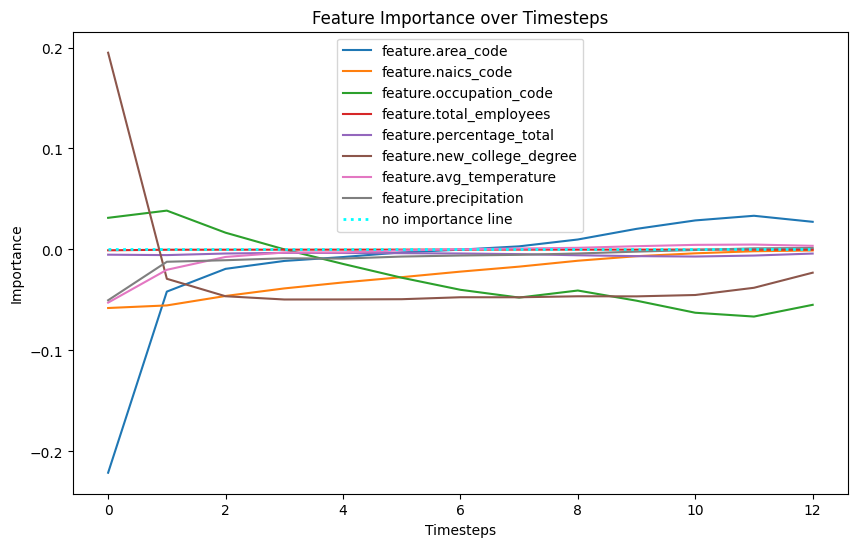

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
for idx, name in zip(range(features), categorical_columns + numerical_columns):
    plt.plot(feature_importance[:, :, idx].mean(axis=0), label=name)
plt.title('Feature Importance over Timesteps')
plt.xlabel('Timesteps')
plt.ylabel('Importance')
plt.hlines(y=0, xmin=0, xmax=12, linewidth=2, color='cyan', linestyles='dotted', label='no importance line')
plt.legend()
plt.show()

From the integrated gradient, we could observe that some of the features are highly support the results (either postitively or negatively):
- feature.naics_code
- feature.occupation_code
- feture.new_college_degree
- feature.area_code

Other features also carry some information but are less significant.
We also observed some interesting patterns such as:
- feature.occupation_code and feature.new_college_degree started as positively supports the wage but gradually shift to negative. The reseverse direction is observed for feature.area_code.


We have also tried various approaches to work with LSTM feature importance but only integrated gradient work. It is difficult to explain feature importance of a timeseries based regressor with multiple output so various libraries like `lime`, `shap` would not work.



# Other attempts

In [64]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00


In [65]:
import numpy as np
import os
from os import path
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation


In [66]:
X_data_1 = X_data[:, -1, :]  # Extract the first label along the last dimension

Y_data_1 = Y_data[:, -1, 0]  # Extract the first label along the last dimension
Y_data_2 = Y_data[:, -1, 1]  # Extract the second label along the last dimension

X_train, X_test, y_train, y_test = train_test_split(X_data_1, Y_data_1, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6066, 8), (1517, 8), (6066,), (1517,))

In [67]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [68]:
batch_size = 128
num_epochs = 3000
learning_rate = 1e-3
size_hidden1 = 512
size_hidden2 = 512
size_hidden3 = 32
size_hidden4 = 1

class DNN(nn.Module):
    def __init__(self, size_hidden1, size_hidden2, size_hidden3, size_hidden4):
        super().__init__()
        self.lin1 = nn.Linear(8, size_hidden1)
        self.tanh1 = nn.Tanh()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.tanh2 = nn.Tanh()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.tanh3 = nn.Tanh()
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        x = self.lin1(input)
        x = self.tanh1(x)
        x = self.lin2(x)
        x = self.tanh2(x)
        x = self.lin3(x)
        x = self.tanh3(x)
        x = self.lin4(x)
        return x

In [70]:
model = DNN(size_hidden1, size_hidden2, size_hidden3, size_hidden4)
model.train()
criterion = nn.L1Loss()

Loading pre-trained model from: /content/drive/MyDrive/Deep_Dive_Project_Group_12/Saved_model/lucrative_industry.pt


<ipython-input-71-09e63adc74b8>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_obj.load_state_dict(torch.load(model_path))


model err:  0.03358611


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


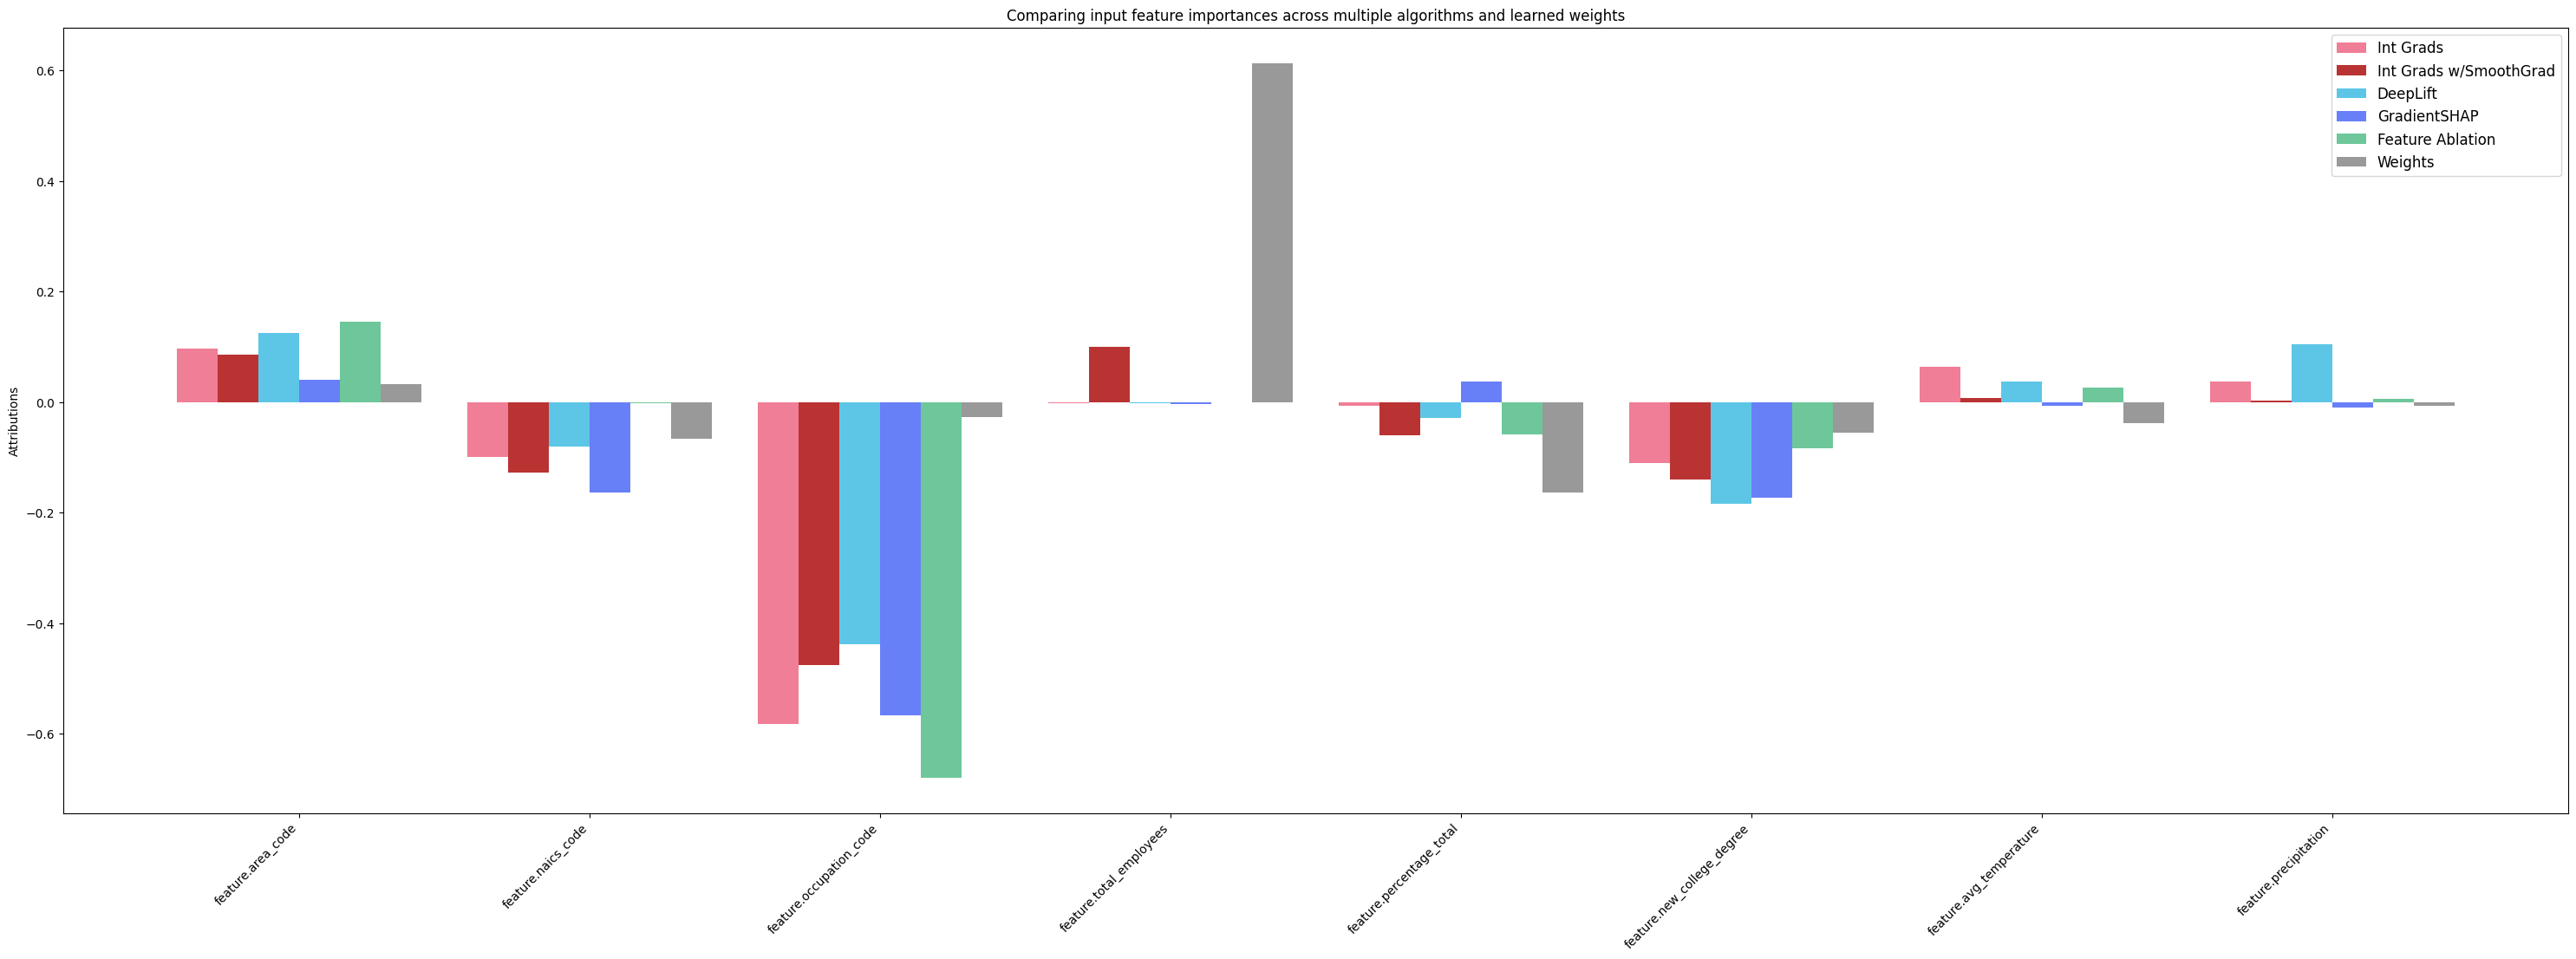

In [71]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.Adam(model_inp.parameters(), lr=learning_rate)
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 10 == 0:
            print('Epoch [%d]/[%d]: accumulated MAE: %.2f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

SAVED_MODEL_PATH = '/content/drive/MyDrive/Deep_Dive_Project_Group_12/Saved_model/lucrative_industry.pt'
os.makedirs(os.path.dirname(SAVED_MODEL_PATH), exist_ok=True)
train_load_save_model(model, SAVED_MODEL_PATH)

model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

feature_names = [feature_columns[i] for i in range(8)]

# Generate x-axis data and labels
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = [feature_names[idx] for idx in x_axis_data]  # Cleaner list comprehension

# Function to normalize attributions
def normalize_attributions(attributions):
    attributions_sum = attributions.detach().numpy().sum(0)
    return attributions_sum / np.linalg.norm(attributions_sum, ord=1)

# Normalize attributions for each method
ig_attr_test_norm_sum = normalize_attributions(ig_attr_test)
ig_nt_attr_test_norm_sum = normalize_attributions(ig_nt_attr_test)
dl_attr_test_norm_sum = normalize_attributions(dl_attr_test)
gs_attr_test_norm_sum = normalize_attributions(gs_attr_test)
fa_attr_test_norm_sum = normalize_attributions(fa_attr_test)

# Normalize linear model weights
y_axis_lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight /= np.linalg.norm(y_axis_lin_weight, ord=1)

# Plot configuration
width = 0.14
legends = [
    'Int Grads', 'Int Grads w/SmoothGrad', 'DeepLift',
    'GradientSHAP', 'Feature Ablation', 'Weights'
]
colors = ['#eb5e7c', '#A90000', '#34b8e0', '#4260f5', '#49ba81', 'grey']
attributions = [
    ig_attr_test_norm_sum, ig_nt_attr_test_norm_sum, dl_attr_test_norm_sum,
    gs_attr_test_norm_sum, fa_attr_test_norm_sum, y_axis_lin_weight
]

plt.figure(figsize=(30, 10))
ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

# Update font sizes globally for consistency
FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE, labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE - 4)

# Create bar plots for each attribution type
for i, (attr, color) in enumerate(zip(attributions, colors)):
    ax.bar(x_axis_data + i * width, attr, width, align='center', alpha=0.8, color=color)

# Configure plot layout
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 2.5 * width)
ax.set_xticklabels(x_axis_data_labels, rotation=45, ha='right')

plt.legend(legends, loc='best')
plt.show()


In [72]:
!pip install shap

### Shap Values

In [73]:
import shap
import torch

model.eval()

# Convert X_test to PyTorch tensor if not already
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Initialize the SHAP Deep Explainer
explainer = shap.DeepExplainer(model, X_train)  # Use training data as the background


<ipython-input-73-316d2918a0ff>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [74]:
# Get SHAP values for the test dataset only for 100 Samples
shap_values = explainer.shap_values(X_test_tensor[:100])
# Remove the extra dimension (squeeze the third dimension)
shap_values = shap_values.squeeze(-1)

In [75]:
print("Shape of X_test:", X_test_tensor.shape)  # Should be (100, 8)
print("Shape of SHAP values:", shap_values.shape)  # Should match (100, 8)

Shape of X_test: torch.Size([1517, 8])
Shape of SHAP values: (100, 8)


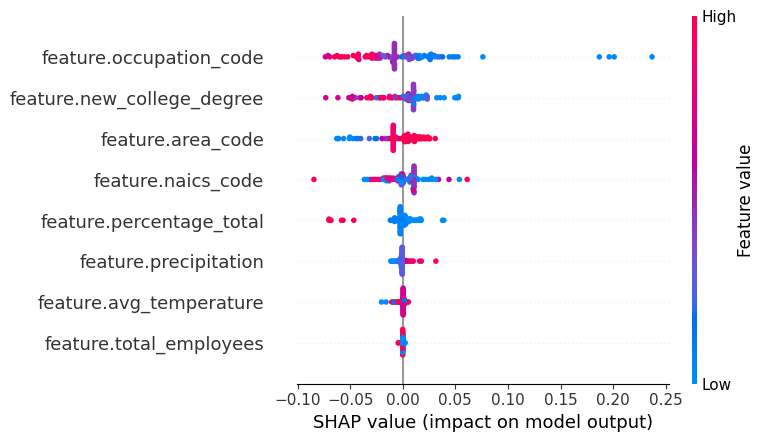

In [76]:
# Ensure the input data is converted to numpy
X_test_numpy = X_test_tensor.numpy()  # If it's a PyTorch tensor

# Generate the summary plot
shap.summary_plot(shap_values, X_test_numpy[:100], feature_names=feature_names)


### Feature Importance

Integrated Gradients, DeepLIFT, GradientSHAP, Feature Ablation, and SHAP values are used to analyze feature importance.
The results of these methods are generally consistent, indicating that the most important features are:
feature.occupation_code
feature.new_college_degree
feature.area_code
feature.naics_code
feature.total_employees
feature.percentage_total


These features are likely to be the most important for predicting the target variable, which is the mean hourly wage

### Model Performance

The model achieves a relatively low error rate, indicating that it is able to predict the target variable with reasonable accuracy.
This suggests that the model is a good fit for the data and that the features selected are relevant for the task.
